<a href="https://colab.research.google.com/github/pierluigiTrocini/deep-learning-quantum-dynamics-prediction/blob/main/Quantum_Dynamics_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep learning models for Qbit trajectories prediction
### A work by Emanuele Colecchia and Pierluigi Trocini

---

### **Project Overview**
Quantum mechanics describes the behavior of matter at a microscopic level, but when systems involve many interacting qubits—characterized by phenomena such as entanglement—they become "Black Boxes" that are difficult to predict using traditional methods. This project proposes **leveraging Deep Learning to model the dynamics of quantum chips**, overcoming the exponential complexity that arises as the number of qubits increases.

By training neural networks on short-term data derived from traditional simulations, the project aims to accurately **forecast long-term physical behavior** that would otherwise be computationally unreachable.



### **Key Implementation Tasks**
To achieve "Enhanced Quantum Dynamics" and effectively "Open the Quantum BlackBox", the following tasks will be implemented:

* **Temporal Optimization**: Identify the shortest time window of input data that yields the most accurate long-term predictions.
* **Super Resolution**: Enable Super Resolution techniques to enhance the quality and granularity of the predicted quantum data.
* **Explainability**: Utilize **attention maps** to explain the neural network's predictions, providing physical insight into the model's decision-making process.

---
*Context: This research builds upon modern innovations in Quantum Computing, such as Google's Willow chip and the foundational work on macroscopic quantum tunneling recognized by the 2025 Nobel Prize in Physics.*

# 1. Dataset Overview
We use a dataset with dynamics simulated for a system of 10 Qbits.<br>
In particular, it's a `numpy` 3D array of `400 sequences` x `1001 timesteps` x `55 variables`.<br>
The file `trajectories.csv` contains the dyncamic of **Magnetizazions $M_j$** and **Correlations $C_{i,j}$**. For each trajetory, the first column contains **time values**, then $N$ magnetization and $N(N-1)/2$ correlations.


In [ ]:
#@title Data extraction and preprocessing
#@markdown Please insert the Google Drive mount folder and the .csv file path in the form below

DRIVE_MOUNT = '/content/drive' # @param
CSV_DRIVE_PATH = '/content/drive/MyDrive/Quantum Dynamics/data/trajectories.csv' # @param


from google.colab import drive
drive.mount(DRIVE_MOUNT)

import pandas as pd

df = pd.read_csv(CSV_DRIVE_PATH, header=None, index_col=False)
print(df.head(2), df.shape)

from sklearn.preprocessing import MinMaxScaler

# 3d reshaping and scaling
raw_data = df.values.reshape(400, 1001, 56)
features = raw_data[:, :, 1:]

print(f"{features.shape}")

features_flat = features.reshape(-1, features.shape[2])
scaler = MinMaxScaler(feature_range = (-1, 1))
features_scaled_flat = scaler.fit_transform(features_flat)

features_scaled = features_scaled_flat.reshape(features.shape)

Mounted at /content/drive
     0         1         2         3         4         5         6         7   \
0  0.00 -0.001528 -0.050912 -0.004092  0.000982 -0.006819 -0.011791  0.043344   
1  0.02 -0.001815 -0.051000 -0.003818  0.000876 -0.006886 -0.011580  0.042898   

        8         9   ...        46        47        48        49        50  \
0  0.00874  0.029128  ...  0.001527  0.002522  0.028148 -0.007095 -0.007200   
1  0.00885  0.028597  ...  0.001749  0.002956  0.027908 -0.006882 -0.006865   

         51        52        53        54        55  
0  0.005317  0.016753 -0.019496  0.002146 -0.014799  
1  0.006107  0.016945 -0.019073  0.002345 -0.013766  

[2 rows x 56 columns] (400400, 56)
(400, 1001, 55)


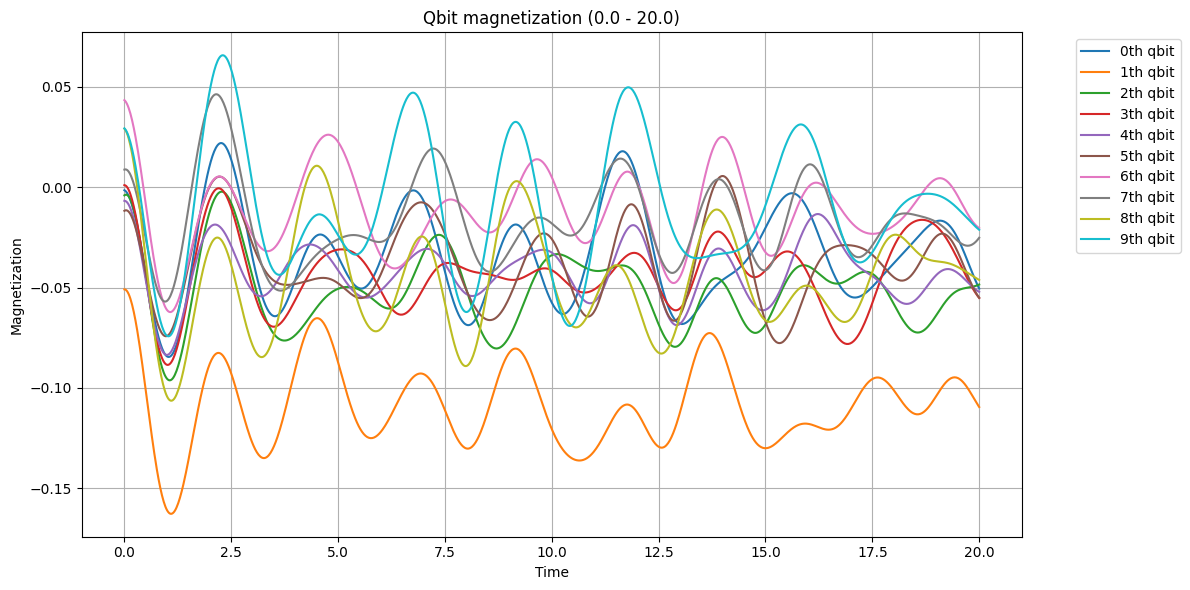

In [ ]:
#@title 1.2 Time window visualization

import numpy as np

TIME_MIN = 0.0 #@param{}
TIME_MAX = 20.0 #@param{}
FIRST_N_QBIT = 10 #@param{}

start_idx = np.where(df.values[:,0] == TIME_MIN)[0][0]
end_idx = np.where(df.values[:,0] == TIME_MAX)[0][0]

x_label = df.values[start_idx : end_idx + 1, 0]
y_label = df.values[start_idx : end_idx + 1, 1:FIRST_N_QBIT + 1]

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i in range(y_label.shape[1]):
    plt.plot(x_label, y_label[:, i], label=f'{i}th qbit')

plt.title(f'Qbit magnetization ({TIME_MIN} - {TIME_MAX})')
plt.xlabel('Time')
plt.ylabel('Magnetization')
plt.grid(True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1)

plt.tight_layout()
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np
import os

# ==============================================================================
# 1. RIDEFINIZIONE CLASSI (Necessario per il caricamento)
# ==============================================================================

def positional_encoding(seq_len, dim):
    half = dim // 2
    pos = np.arange(seq_len)[:, None]
    div = np.arange(half)[None, :] / half
    angles = pos / np.power(10000, div)
    enc = np.concatenate([np.sin(angles), np.cos(angles)], axis=-1)
    return tf.cast(enc, tf.float32)

class TimeEmbedding(tf.keras.layers.Layer):
    def __init__(self, dim, max_len, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.max_len = max_len # Salvo per get_config
        self.proj = tf.keras.layers.Dense(dim)
        self.pe = positional_encoding(max_len, dim)

    def call(self, x):
        t = tf.shape(x)[1]
        x = self.proj(x)
        x *= tf.math.sqrt(tf.cast(self.dim, tf.float32))
        return x + self.pe[None, :t, :]

    def get_config(self):
        config = super().get_config()
        config.update({"dim": self.dim, "max_len": self.max_len})
        return config

class FeedForwardBlock(tf.keras.layers.Layer):
    def __init__(self, dim, hidden, drop, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.hidden = hidden
        self.drop = drop
        self.net = tf.keras.Sequential([
            tf.keras.layers.Dense(hidden, activation="relu"),
            tf.keras.layers.Dense(dim),
            tf.keras.layers.Dropout(drop)
        ])
        self.norm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x):
        return self.norm(self.add([x, self.net(x)]))

    def get_config(self):
        config = super().get_config()
        config.update({"dim": self.dim, "hidden": self.hidden, "drop": self.drop})
        return config

class SelfAttentionBlock(tf.keras.layers.Layer):
    def __init__(self, heads, dim, drop, **kwargs):
        super().__init__(**kwargs)
        self.heads = heads
        self.dim = dim
        self.drop = drop
        self.attn = tf.keras.layers.MultiHeadAttention(
            num_heads=heads, key_dim=dim, dropout=drop
        )
        self.norm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x):
        out = self.attn(x, x, x)
        return self.norm(self.add([x, out]))

    def get_config(self):
        config = super().get_config()
        config.update({"heads": self.heads, "dim": self.dim, "drop": self.drop})
        return config

class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self, dim, heads, hidden, drop, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.heads = heads
        self.hidden = hidden
        self.drop = drop
        self.attn = SelfAttentionBlock(heads, dim, drop)
        self.ffn = FeedForwardBlock(dim, hidden, drop)

    def call(self, x):
        x = self.attn(x)
        return self.ffn(x)

    def get_config(self):
        config = super().get_config()
        config.update({"dim": self.dim, "heads": self.heads,
                       "hidden": self.hidden, "drop": self.drop})
        return config

# Dizionario per dire a Keras come leggere i file
CUSTOM_OBJECTS = {
    "TimeEmbedding": TimeEmbedding,
    "FeedForwardBlock": FeedForwardBlock,
    "SelfAttentionBlock": SelfAttentionBlock,
    "EncoderBlock": EncoderBlock
}

# ==============================================================================
# 2. CONFIGURAZIONE E BUILDER
# ==============================================================================

TIME_WINDOW = "50" #@param [20, 50]
MODEL = "Transformer" #@param["LSTM", "Transformer"]
ENABLE_SUPER_RESOLUTION = False #@param {type:"boolean"}

# Paths (Aggiornati con i tuoi)
WINDOW_20_LSTM_CUSTOM = '/content/drive/MyDrive/Colab Notebooks/Progetto Deep Learning/LSTM_models/window_20/LSTM_20.keras'
WINDOW_50_LSTM_CUSTOM = '/content/drive/MyDrive/Colab Notebooks/Progetto Deep Learning/LSTM_models/window_50/LSTM_50.keras'
TRANSFORMER_WIN_20 = '/content/drive/MyDrive/Colab Notebooks/Progetto Deep Learning/unified/model_win20.keras'
TRANSFORMER_WIN_50 = '/content/drive/MyDrive/Colab Notebooks/Progetto Deep Learning/unified/model_win50.keras'
SUPER_RESOLUTION = '/content/drive/MyDrive/Colab Notebooks/Progetto Deep Learning/unified/sr_model_best.keras'

def build_model():
    print(f"Costruzione modello: {MODEL} | Window: {TIME_WINDOW} | SR: {ENABLE_SUPER_RESOLUTION}")

    # Selezione path modello principale
    if MODEL == "LSTM":
        path = WINDOW_20_LSTM_CUSTOM if str(TIME_WINDOW) == "20" else WINDOW_50_LSTM_CUSTOM
    else:
        path = TRANSFORMER_WIN_20 if str(TIME_WINDOW) == "20" else TRANSFORMER_WIN_50

    # 1. Caricamento Modello Predittivo
    print(f"Loading Main Model: {path}")
    try:
        # Passiamo custom_objects qui!
        main_model = tf.keras.models.load_model(path, custom_objects=CUSTOM_OBJECTS, compile=False)
    except Exception as e:
        print(f"ERRORE caricamento Main Model: {e}")
        return None

    # Se non serve SR, finiamo qui
    if not ENABLE_SUPER_RESOLUTION:
        return main_model

    # 2. Caricamento Super Resolution
    print(f"Loading SR Model: {SUPER_RESOLUTION}")
    try:
        sr_model = tf.keras.models.load_model(SUPER_RESOLUTION, custom_objects=CUSTOM_OBJECTS, compile=False)
    except Exception as e:
        print(f"ERRORE caricamento SR Model: {e}")
        return None

    # 3. Creazione Pipeline (SR -> Crop -> Prediction)
    # Nota: SR esce a 100 steps.
    # Se il modello predittivo vuole 50 steps, dobbiamo prendere gli ultimi 50.
    # Se il modello predittivo vuole 20 steps, prendiamo gli ultimi 20.

    req_window = int(TIME_WINDOW)

    # Input della pipeline (Low Res, 50 steps)
    input_lr = tf.keras.Input(shape=(50, 55), name="input_low_res")

    # Passaggio 1: Super Resolution (50 -> 100)
    x_hr = sr_model(input_lr) # Shape: (Batch, 100, 55)

    # Passaggio 2: Adattamento dimensioni (Slicing)
    # Prendiamo gli ultimi 'req_window' steps dall'output SR
    # Se window=50, prendiamo gli ultimi 50 dei 100 generati.
    x_cropped = tf.keras.layers.Lambda(
        lambda x: x[:, -req_window:, :],
        name=f"crop_last_{req_window}"
    )(x_hr)

    # Passaggio 3: Predizione
    out_pred = main_model(x_cropped)

    # Modello finale end-to-end
    final_model = tf.keras.Model(inputs=input_lr, outputs=out_pred, name="SR_to_Prediction_Pipeline")

    return final_model

# Esecuzione
inference_model = build_model()
if inference_model:
    inference_model.summary()

Costruzione modello: Transformer | Window: 50 | SR: False
Loading Main Model: /content/drive/MyDrive/Colab Notebooks/Progetto Deep Learning/unified/model_win50.keras


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'time_embedding_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'encoder_block_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 50, 55)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_embedding_1                │ (None, 50, 64)         │         3,584 │
│ (TimeEmbedding)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_block_2 (EncoderBlock)  │ (None, 50, 64)         │        50,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 55)             │         7,095 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,047 (269.71 KB)

 Trainable params: 69,047 (269.71 KB)

 Non-trainable params: 0 (0.00 B)


--- CONFIGURAZIONE GRAFICO ---
Time Window:       50 steps
Durata Predizione: 1.00s
Intervallo:        15.0s -> 16.00s
Calcolo predizione in corso...


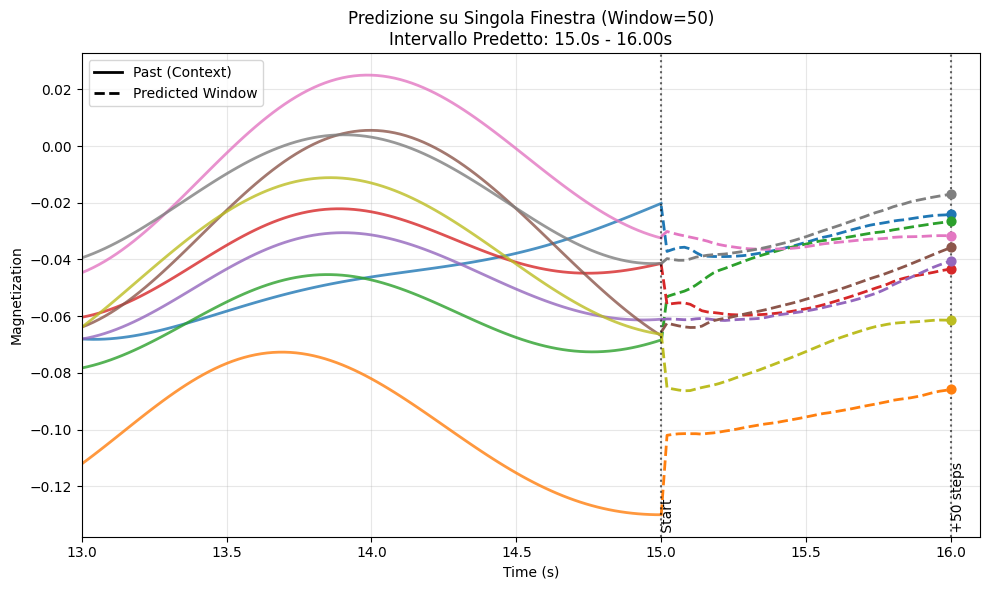

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
import os

# ==============================================================================
# 0. SETUP E CARICAMENTO DATI (FIXED)
# ==============================================================================

# 1. Montiamo Google Drive
if not os.path.exists('/content/drive'):
    print("Montaggio Google Drive...")
    drive.mount('/content/drive')

# 2. Definiamo il percorso corretto
# MODIFICA QUI SE IL FILE E' IN UNA CARTELLA DIVERSA
CSV_FULL_PATH = '/content/drive/MyDrive/Colab Notebooks/Progetto Deep Learning/trajectories.csv'

if not 'data_hr' in locals():
    print(f"Caricamento dataset da: {CSV_FULL_PATH} ...")
    try:
        if not os.path.exists(CSV_FULL_PATH):
            raise FileNotFoundError(f"File non trovato nel percorso: {CSV_FULL_PATH}")

        df = pd.read_csv(CSV_FULL_PATH, header=None)

        # Reshape standard
        raw_data = df.values.reshape(400, 1001, 56)
        # Rimuoviamo la colonna tempo -> 55 features
        data_hr = raw_data[:, :, 1:]

        # Scaler
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaler.fit(data_hr.reshape(-1, 55))
        print(f"✓ Dataset caricato con successo: {data_hr.shape}")

    except Exception as e:
        print(f"\nERRORE CRITICO: {e}")
        print("Suggerimento: Controlla che il file 'trajectories.csv' sia esattamente in quella cartella di Drive.")
        print("Se è nella root del Drive, cambia il percorso in: '/content/drive/MyDrive/trajectories.csv'")
        raise e

# ==============================================================================
# 1. PARAMETRI BASE
# ==============================================================================
SPLIT_TIME = 15.0       #@param {type:"number"}
TRAJ_IDX = 0            #@param {type:"integer"}
FIRST_N_QBIT = 9        #@param {type:"integer"}

# Controllo modello caricato
if 'inference_model' not in locals() or inference_model is None:
    raise NameError("Errore: 'inference_model' non è definito. Esegui la cella 'Build your model' prima di questa.")

# ==============================================================================
# 2. CONFIGURAZIONE AUTOMATICA
# ==============================================================================
dt = 0.02
# TIME_WINDOW e ENABLE_SUPER_RESOLUTION devono essere definiti nelle celle precedenti
# Se non lo sono, li forziamo a valori di default per evitare crash, ma dovrebbero esserci
if 'TIME_WINDOW' not in locals(): TIME_WINDOW = 50
if 'ENABLE_SUPER_RESOLUTION' not in locals(): ENABLE_SUPER_RESOLUTION = False

steps_to_predict = int(TIME_WINDOW)
prediction_seconds = steps_to_predict * dt
END_TIME = SPLIT_TIME + prediction_seconds

req_window_steps = 100 if ENABLE_SUPER_RESOLUTION else int(TIME_WINDOW)
visual_history_seconds = prediction_seconds * 2.0

print(f"\n--- CONFIGURAZIONE GRAFICO ---")
print(f"Time Window:       {steps_to_predict} steps")
print(f"Durata Predizione: {prediction_seconds:.2f}s")
print(f"Intervallo:        {SPLIT_TIME}s -> {END_TIME:.2f}s")

# ==============================================================================
# 3. PREDIZIONE
# ==============================================================================
start_step_idx = int(SPLIT_TIME / dt)

if start_step_idx < req_window_steps:
    raise ValueError(f"SPLIT_TIME troppo basso. Serve storico sufficiente.")

current_history = data_hr[TRAJ_IDX, start_step_idx - req_window_steps : start_step_idx, :].copy()

future_predictions = []
future_predictions.append(current_history[-1])

print("Calcolo predizione in corso...")
for i in range(steps_to_predict):
    if ENABLE_SUPER_RESOLUTION:
        input_seq = current_history[::2]
    else:
        input_seq = current_history

    input_norm = scaler.transform(input_seq)
    pred_norm = inference_model.predict(input_norm[np.newaxis, :, :], verbose=0)
    pred_real = scaler.inverse_transform(pred_norm)[0]

    future_predictions.append(pred_real)
    current_history = np.vstack([current_history[1:], pred_real])

future_predictions = np.array(future_predictions)

# ==============================================================================
# 4. PLOTTING
# ==============================================================================
plt.figure(figsize=(10, 6))
colors = plt.cm.tab10(np.linspace(0, 1, 10))

vis_steps = int(visual_history_seconds / dt)
vis_start_idx = max(0, start_step_idx - vis_steps)

history_vis_data = data_hr[TRAJ_IDX, vis_start_idx : start_step_idx + 1, :]
time_axis_hist = np.linspace(SPLIT_TIME - (len(history_vis_data)-1)*dt, SPLIT_TIME, len(history_vis_data))
time_axis_pred = np.linspace(SPLIT_TIME, END_TIME, len(future_predictions))

for i in range(FIRST_N_QBIT):
    col = colors[i]
    # Passato
    plt.plot(time_axis_hist, history_vis_data[:, i], color=col, linestyle='-', linewidth=2.0, alpha=0.8)
    # Futuro
    plt.plot(time_axis_pred, future_predictions[:, i], color=col, linestyle='--', linewidth=2.0)
    # Punto finale
    plt.scatter([END_TIME], [future_predictions[-1, i]], color=col, s=40, zorder=5)

plt.axvline(x=SPLIT_TIME, color='k', linestyle=':', alpha=0.6)
plt.text(SPLIT_TIME, plt.ylim()[0], " Start", rotation=90, verticalalignment='bottom')

plt.axvline(x=END_TIME, color='k', linestyle=':', alpha=0.6)
plt.text(END_TIME, plt.ylim()[0], f" +{steps_to_predict} steps", rotation=90, verticalalignment='bottom')

plt.xlim(time_axis_hist[0], END_TIME + (dt*5))
plt.title(f'Predizione su Singola Finestra (Window={TIME_WINDOW})\nIntervallo Predetto: {SPLIT_TIME}s - {END_TIME:.2f}s')
plt.xlabel('Time (s)')
plt.ylabel('Magnetization')
plt.grid(True, alpha=0.3)

custom_lines = [Line2D([0], [0], color='black', lw=2, linestyle='-'),
                Line2D([0], [0], color='black', lw=2, linestyle='--')]
plt.legend(custom_lines, ['Past (Context)', 'Predicted Window'], loc='upper left')

plt.tight_layout()
plt.show()